In [1]:
%reset -f
from pythonrc import *

# Simple test

## Setup the environment and the configuration

In [2]:
tunnel.extra_attributes['rate_limit'] = 0.1
voithschneider_port.extra_attributes['rate_limit'] = 0.1
voithschneider_starboard.extra_attributes['rate_limit'] = 0.1


def initialize_allocator(
    allocator_type: skadipy.allocator.AllocatorBase, **kwargs
) -> skadipy.allocator.AllocatorBase:
    return allocator_type(
        actuators=[
            tunnel,
            voithschneider_port,
            voithschneider_starboard,
        ],
        force_torque_components=[
            skadipy.allocator.ForceTorqueComponent.X,
            skadipy.allocator.ForceTorqueComponent.Y,
            skadipy.allocator.ForceTorqueComponent.N,
        ],
        **kwargs,
    )


time_step=0.1
gamma = [0.1, 0.1]
mu    = [0.1, 0.1]
rho   = [0.1, 0.1]
lambda_p = [0.99, 0.0]

def initialize_allocators():
    a= []
    for g,m,r,l in zip(gamma, mu, rho, lambda_p):
        a.append(
            initialize_allocator(
                skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
                gamma=g, mu=m, rho=r, time_step=time_step, lambda_=l
            )
        )
    a.append(
        initialize_allocator(
            skadipy.allocator.reference_filters.MinimumMagnitude,
            gamma=0.1, mu=0.1, rho=0.1, time_step=time_step
        )
    )
    return a


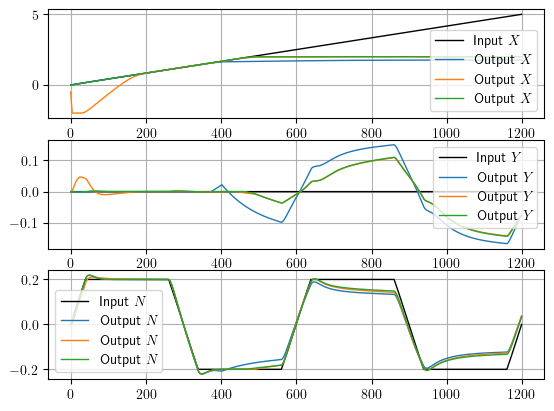

In [3]:
n = 1200
tau_cmd = np.zeros((n, 6))
tau_cmd[:,0] = np.linspace(0, 5, n)
tau_cmd[:,5] = gen_clipped_sin(n, 0.5, 2.0, 0.0, 0, -0.2, 0.2)

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd, allocators=initialize_allocators())
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist)

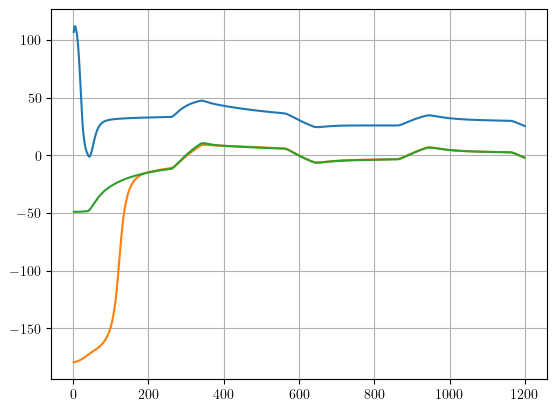

In [4]:
angles = []
for control_input in xi_hist:
    a = np.empty((len(control_input), 2))
    for i, u in enumerate(control_input):
        a2 = np.arctan2(u[2], u[1])
        a3 = np.arctan2(u[4], u[3])
        a[i] = np.array([a2])
    angles.append(a)
for _, angle in enumerate(angles):
    angle[0:2,0] = None
plt.clf()
for i, angle in enumerate(angles):
    plt.plot(np.rad2deg(angle[:,0]))
    pass



plt.grid(True)

In [5]:
# gamma.append(0.1)
# mu.append(0.1)
# rho.append(0.1)
# lambda_p.append(0.0)

# save_mat(
#     filename="data/13.mat",
#     inputs=tau,
#     xi=xi,
#     thetas=thetas,
#     outputs=outputs,
#     rho=rho,
#     gamma=gamma,
#     mu=mu,
#     lambda_p=lambda_p,
#     thruster=voithschneider_port
# )